In [22]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


dataset_root = '1-condition-splited-data'


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=dataset_root + '/train', transform=transform)
test_dataset = ImageFolder(root=dataset_root + '/test', transform=transform)
val_dataset = ImageFolder(root=dataset_root+"/validation",transform=transform)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [23]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(input_size, hidden_size*2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size*2, hidden_size*4)
        self.relu2 = nn.ReLU()
        self.batchNormalization1 = nn.BatchNorm1d(hidden_size*4) 
        self.dropout1 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(hidden_size*4, hidden_size * 2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu4 = nn.ReLU()
        self.batchNormalization2 = nn.BatchNorm1d(hidden_size) 
        self.dropout2 = nn.Dropout(0.4)

        self.fc5 = nn.Linear(hidden_size , hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size , num_classes)

    def forward(self, x):
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.batchNormalization1(x)
        x = self.dropout1(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.batchNormalization2(x)
        x = self.dropout2(x)

        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)

        return x


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = (224,224,3)

W,H,C = INPUT_SIZE
input_size = W*H*C
model = NeuralNetwork(input_size,64,len(train_dataset.classes)).to(device)

saved_weights_path = "ann-condition-1-fit.pth"

model.load_state_dict(torch.load(saved_weights_path))

<All keys matched successfully>

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        
        
        all_labels += labels.cpu().numpy().tolist()
        all_predictions += predicted.cpu().numpy().tolist()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset) * 100.0

print(f'Test Loss: {test_loss}, Test Accuracy: {accuracy}%')


Test Loss: 0.015522482530233295, Test Accuracy: 81.06666666666666%


Test Loss: 0.0155
Test Accuracy : 81.0667
Precision: 0.8087
Recall : 0.8107
F1 Score : 0.8094
Confusion Matrix:
[[727  46 227]
 [ 18 981   1]
 [268   8 724]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1000
           1       0.95      0.98      0.96      1000
           2       0.76      0.72      0.74      1000

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



<Axes: >

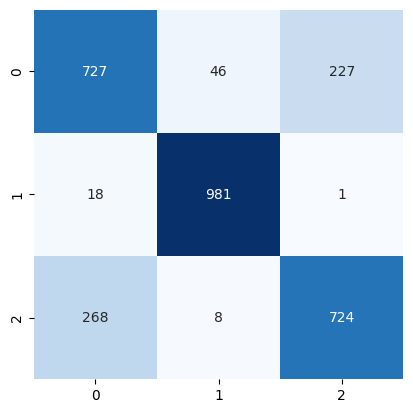

In [26]:
# Accuracy,  Precision, Recall ve F1 skoru, Karmaşıklık Matrisi, Classification Report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
cm = confusion_matrix(all_labels, all_predictions)

print(f'Test Loss: {test_loss:.4f}')
print(f"Test Accuracy : {accuracy:.4f}")
print(f'Precision: {precision:.4f}')
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(len(test_dataset.classes))]))

sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)